In [21]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits, fetch_openml
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import rand_score, silhouette_score, homogeneity_completeness_v_measure, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [22]:
X , y = load_digits(return_X_y=True, as_frame=True)
digits = load_digits()
X

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


In [23]:
y

0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: target, Length: 1797, dtype: int32

In [24]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

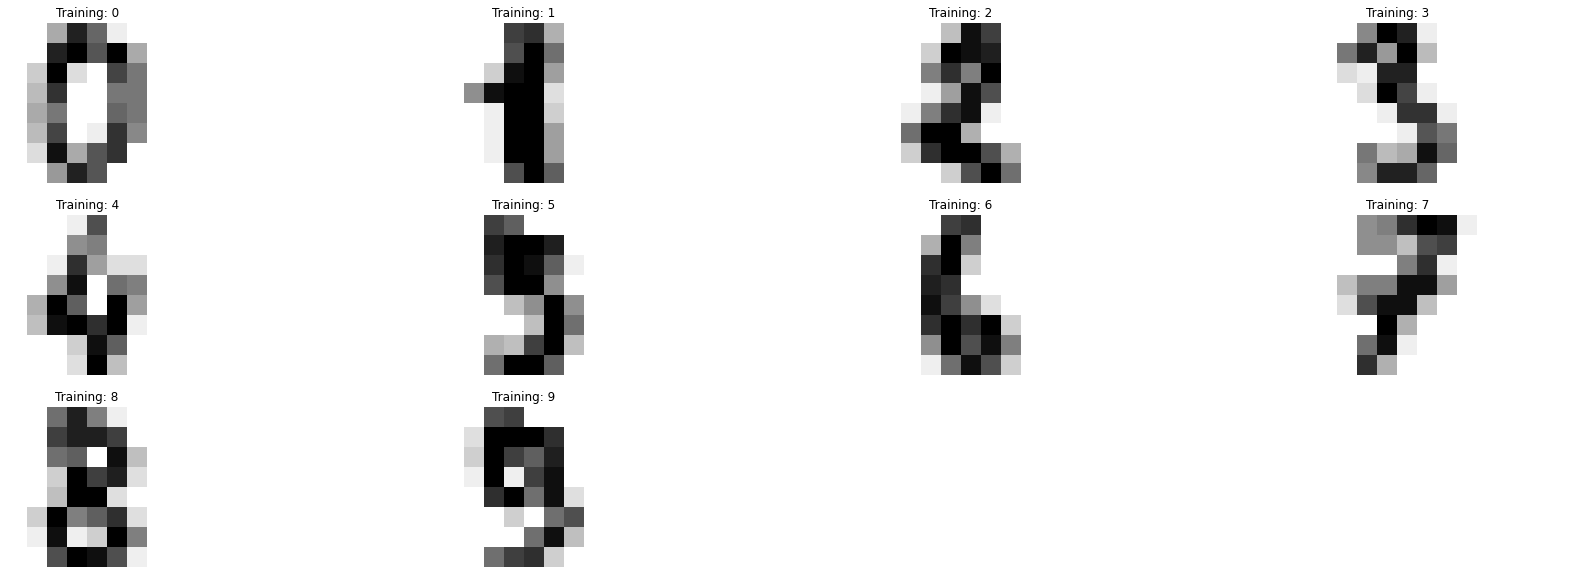

In [25]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image, label in zip(axes.flatten()[:10], digits.images, digits.target):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [26]:
k_pred = KMeans(n_clusters=10, init='k-means++', n_init=2000).fit_predict(X)
a_pred = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(X)

In [27]:
print('KMeans score:',rand_score(y,k_pred))
print('AgglomerativeClustering score:',rand_score(y,a_pred))

KMeans score: 0.9388011199066001
AgglomerativeClustering score: 0.9612333349445314


Как мы видим AgglomerativeClustering отработал лучше и стабильней, так как KMeans очень сильно может изменяться.

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [28]:
mean_num_k=[]
mean_num_a=[]
mean_num_orig=[]
for num in range(10):
    mean_num_k.append([])
    mean_num_a.append([])
    mean_num_orig.append([])
    for c in range(8):
        mean_num_k[num].append([])
        mean_num_a[num].append([])
        mean_num_orig[num].append([])
        for v in range(8):
            mean_num_k[num][c].append(digits.images[k_pred==num,c,v].mean())
            mean_num_a[num][c].append(digits.images[a_pred==num,c,v].mean())
            mean_num_orig[num][c].append(digits.images[y==num,c,v].mean())

Центры кластеров оригинальной кластеризации


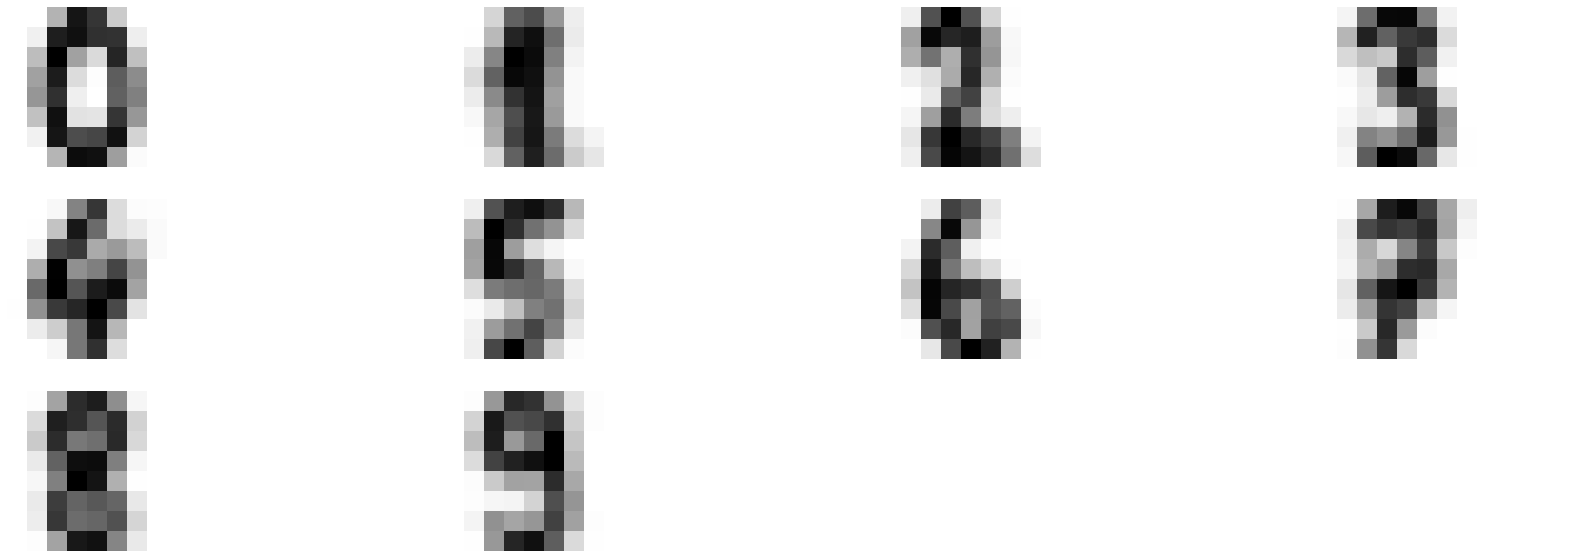

In [29]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
print('Центры кластеров оригинальной кластеризации')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image, label in zip(axes.flatten(), mean_num_orig, digits.target):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

Центры кластеров KMeans


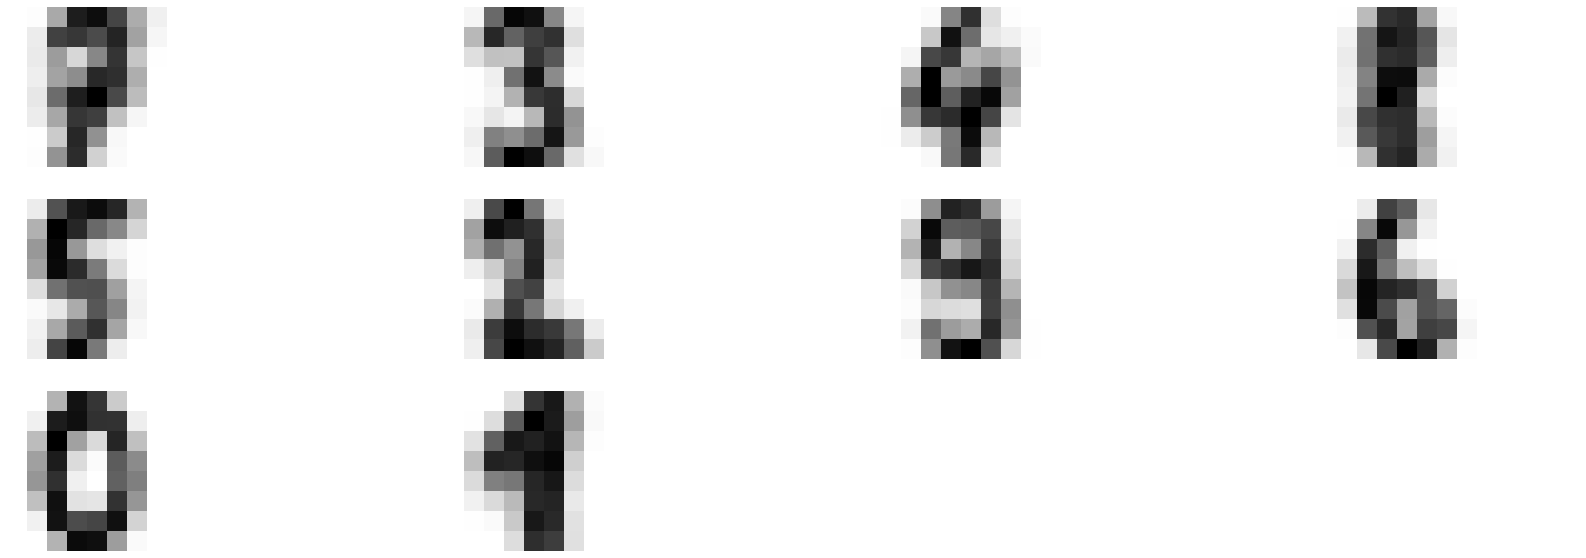

In [30]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
print('Центры кластеров KMeans')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image, label in zip(axes.flatten(), mean_num_k, digits.target):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

Центры кластеров AgglomerativeClustering


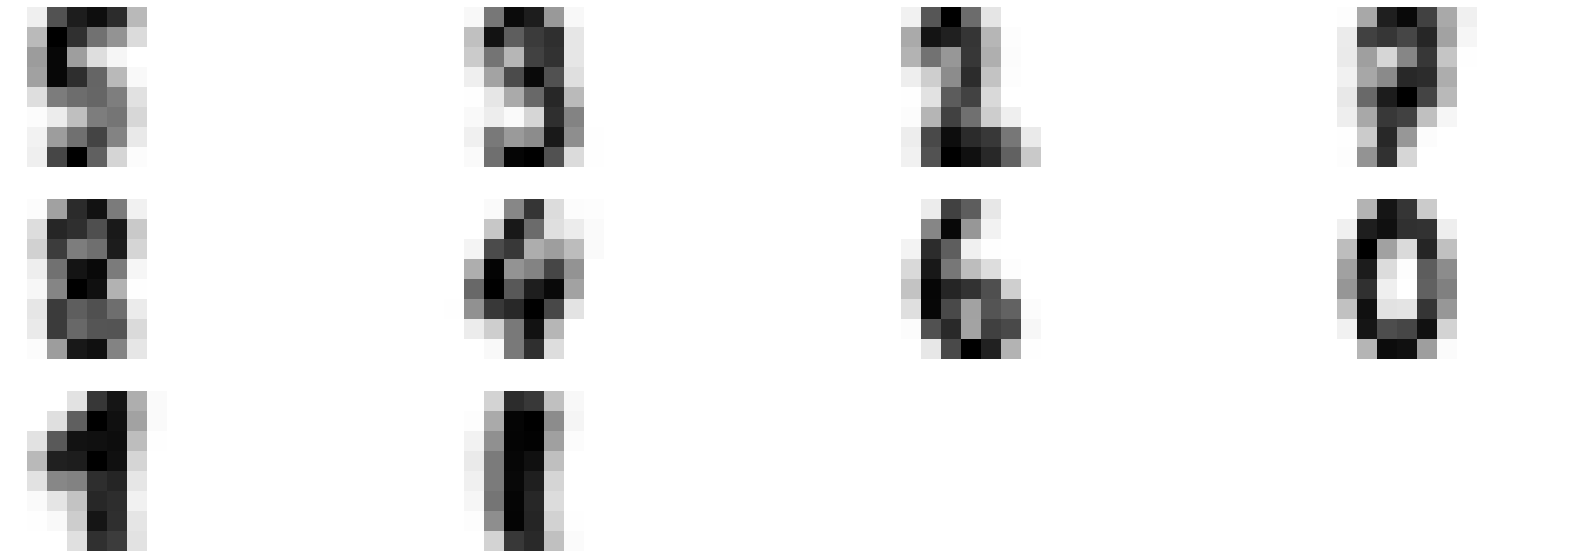

In [31]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
print('Центры кластеров AgglomerativeClustering')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image, label in zip(axes.flatten(), mean_num_a, digits.target):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [32]:
score=[[],[]]
for i in range(2,21):
    k_pred = KMeans(n_clusters=i, init='k-means++', n_init=100).fit_predict(X)
    a_pred = AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(X)
    score[0].append(silhouette_score(X, a_pred))
    score[1].append(silhouette_score(X, k_pred))

Maximum silhouette_score in AgglomerativeClustering is 9
Maximum silhouette_score in KMeans is 16


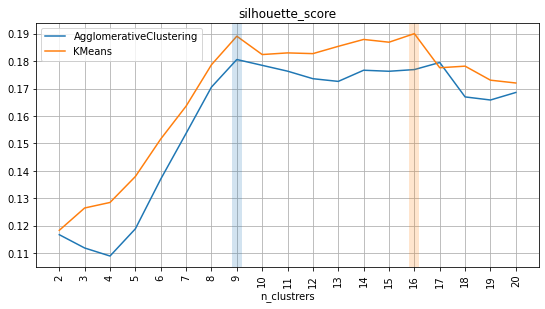

In [33]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2,21), score[0], label='AgglomerativeClustering')
plt.plot(range(2,21), score[1], color='C1', label='KMeans')
plt.xticks(range(2,21), rotation='vertical')
print('Maximum silhouette_score in AgglomerativeClustering is', range(2,21)[np.argmax(score[0])])
print('Maximum silhouette_score in KMeans is', range(2,21)[np.argmax(score[1])])
plt.axvline(range(2,21)[np.argmax(score[0])], lw=10, alpha=0.2)
plt.axvline(range(2,21)[np.argmax(score[1])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.xlabel('n_clustrers')
plt.legend(loc='upper left')
plt.title('silhouette_score')              
plt.show()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [34]:
score=[[[],[],[]],[[],[],[]]]
for i in range(2,21):
    k_pred = KMeans(n_clusters=i, init='k-means++', n_init=100).fit_predict(X)
    a_pred = AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(X)
    k=homogeneity_completeness_v_measure(y, k_pred)
    a=homogeneity_completeness_v_measure(y, a_pred)
    score[0][0].append(a[0])
    score[0][1].append(a[1])
    score[0][2].append(a[2])
    score[1][0].append(k[0])
    score[1][1].append(k[1])
    score[1][2].append(k[2])

Maximum homogeneity in AgglomerativeClustering is 20
Maximum homogeneity in KMeans is 17


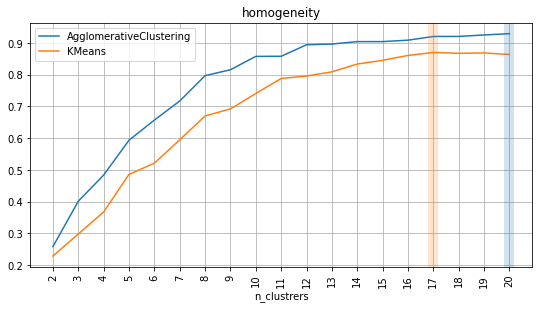

In [35]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2,21), score[0][0], label='AgglomerativeClustering')
plt.plot(range(2,21), score[1][0], color='C1', label='KMeans')
plt.xticks(range(2,21), rotation='vertical')
print('Maximum homogeneity in AgglomerativeClustering is', range(2,21)[np.argmax(score[0][0])])
print('Maximum homogeneity in KMeans is', range(2,21)[np.argmax(score[1][0])])
plt.axvline(range(2,21)[np.argmax(score[0][0])], lw=10, alpha=0.2)
plt.axvline(range(2,21)[np.argmax(score[1][0])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_clustrers')
plt.title('homogeneity')                
plt.show()

Maximum completeness in AgglomerativeClustering is 8
Maximum completeness in KMeans is 8


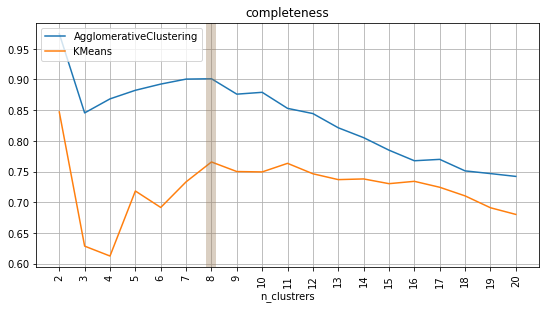

In [36]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2,21), score[0][1], label='AgglomerativeClustering')
plt.plot(range(2,21), score[1][1], color='C1', label='KMeans')
plt.xticks(range(2,21), rotation='vertical')
print('Maximum completeness in AgglomerativeClustering is', range(2,21)[np.argmax(score[0][1][3:])+3])
print('Maximum completeness in KMeans is', range(2,21)[np.argmax(score[1][1][3:])+3])
plt.axvline(range(2,21)[np.argmax(score[0][1][3:])+3], lw=10, alpha=0.2)
plt.axvline(range(2,21)[np.argmax(score[1][1][3:])+3], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_clustrers')
plt.title('completeness')              
plt.show()

Maximum v_measure in AgglomerativeClustering is 12
Maximum v_measure in KMeans is 16


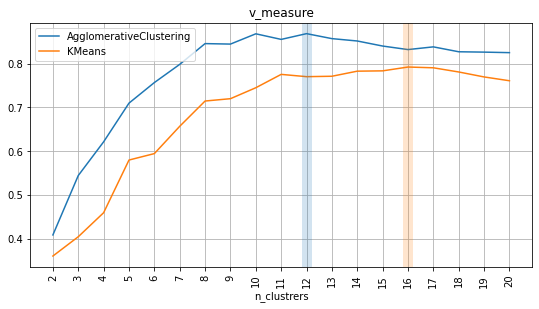

In [37]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2,21), score[0][2], label='AgglomerativeClustering')
plt.plot(range(2,21), score[1][2], color='C1', label='KMeans')
plt.xticks(range(2,21), rotation='vertical')
print('Maximum v_measure in AgglomerativeClustering is', range(2,21)[np.argmax(score[0][2])])
print('Maximum v_measure in KMeans is', range(2,21)[np.argmax(score[1][2])])
plt.axvline(range(2,21)[np.argmax(score[0][2])], lw=10, alpha=0.2)
plt.axvline(range(2,21)[np.argmax(score[1][2])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_clustrers')
plt.title('v_measure')              
plt.show()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [38]:
score = [[[],[],[]],[[],[],[]]]
for i in range(1,65):
    if i < 64:
        x = TruncatedSVD(n_components=i).fit_transform(X)
    else:
        x = X
    k_pred = KMeans(n_clusters=10, init='k-means++', n_init=100).fit_predict(x)
    a_pred = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(x)
    score[0][0].append(silhouette_score(x, a_pred))
    score[1][0].append(silhouette_score(x, k_pred))
    score[0][1].append(v_measure_score(y, a_pred))
    score[1][1].append(v_measure_score(y, k_pred))
    score[0][2].append(rand_score(y, a_pred))
    score[1][2].append(rand_score(y, k_pred))

Maximum silhouette_score in AgglomerativeClustering is 1
Maximum silhouette_score in KMeans is 1


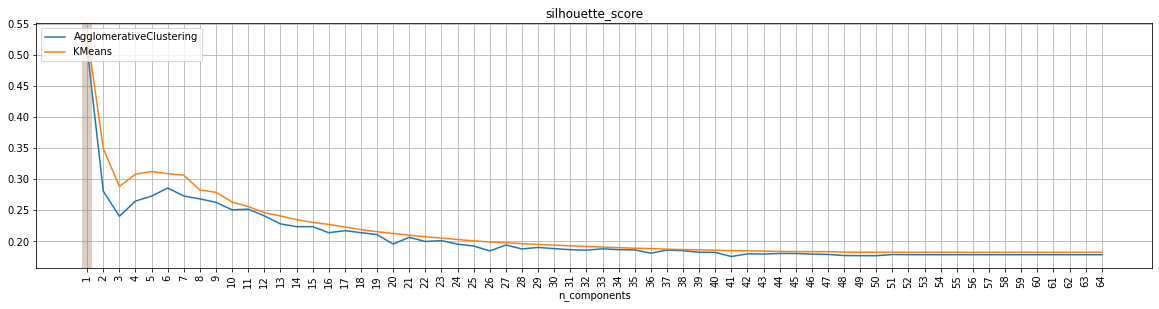

In [39]:
plt.figure(figsize=(20, 4.5))
plt.plot(range(1,65), score[0][0], label='AgglomerativeClustering')
plt.plot(range(1,65), score[1][0], color='C1', label='KMeans')
plt.xticks(range(1,65), rotation='vertical')
print('Maximum silhouette_score in AgglomerativeClustering is', range(1,65)[np.argmax(score[0][0])])
print('Maximum silhouette_score in KMeans is', range(1,65)[np.argmax(score[1][0])])
plt.axvline(range(1,65)[np.argmax(score[0][0])], lw=10, alpha=0.2)
plt.axvline(range(1,65)[np.argmax(score[1][0])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_components')
plt.title('silhouette_score')                
plt.show()

Maximum v_measure in AgglomerativeClustering is 51
Maximum v_measure in KMeans is 47


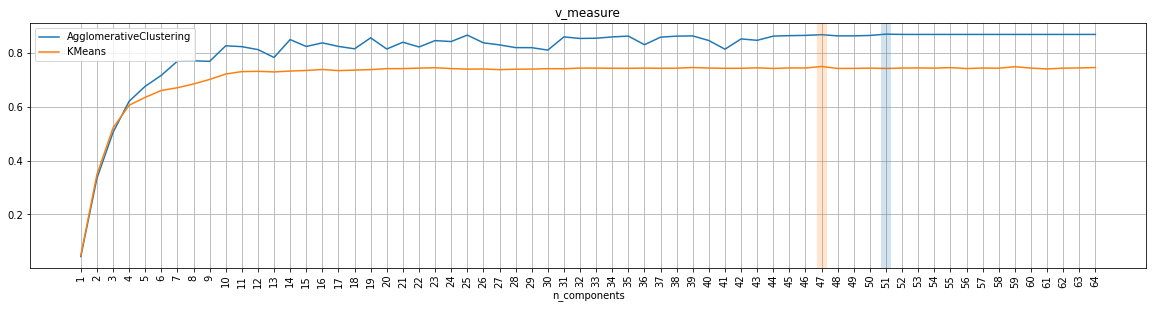

In [40]:
plt.figure(figsize=(20, 4.5))
plt.plot(range(1,65), score[0][1], label='AgglomerativeClustering')
plt.plot(range(1,65), score[1][1], color='C1', label='KMeans')
plt.xticks(range(1,65), rotation='vertical')
print('Maximum v_measure in AgglomerativeClustering is', range(1,65)[np.argmax(score[0][1][3:])+3])
print('Maximum v_measure in KMeans is', range(1,65)[np.argmax(score[1][1][3:])+3])
plt.axvline(range(1,65)[np.argmax(score[0][1])], lw=10, alpha=0.2)
plt.axvline(range(1,65)[np.argmax(score[1][1])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_components')
plt.title('v_measure')              
plt.show()

Maximum rand_score in AgglomerativeClustering is 51
Maximum rand_score in KMeans is 47


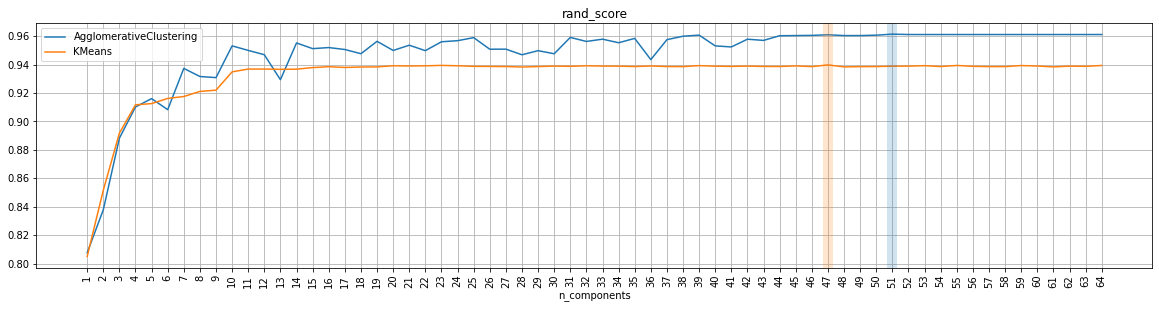

In [41]:
plt.figure(figsize=(20, 4.5))
plt.plot(range(1,65), score[0][2], label='AgglomerativeClustering')
plt.plot(range(1,65), score[1][2], color='C1', label='KMeans')
plt.xticks(range(1,65), rotation='vertical')
print('Maximum rand_score in AgglomerativeClustering is', range(1,65)[np.argmax(score[0][2])])
print('Maximum rand_score in KMeans is', range(1,65)[np.argmax(score[1][2])])
plt.axvline(range(1,65)[np.argmax(score[0][2])], lw=10, alpha=0.2)
plt.axvline(range(1,65)[np.argmax(score[1][2])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_components') 
plt.title('rand_score')              
plt.show()

Как видно из графиков, максимальное значение принимает и в данных с меньшим количестом признаков.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [42]:
x=TSNE().fit_transform(X)
x

array([[  6.359725 ,  62.774586 ],
       [ -4.350619 , -41.72462  ],
       [-17.18357  , -21.665842 ],
       ...,
       [ -4.921181 , -20.07926  ],
       [  3.5538585,  10.756491 ],
       [ -5.9642224, -14.678543 ]], dtype=float32)

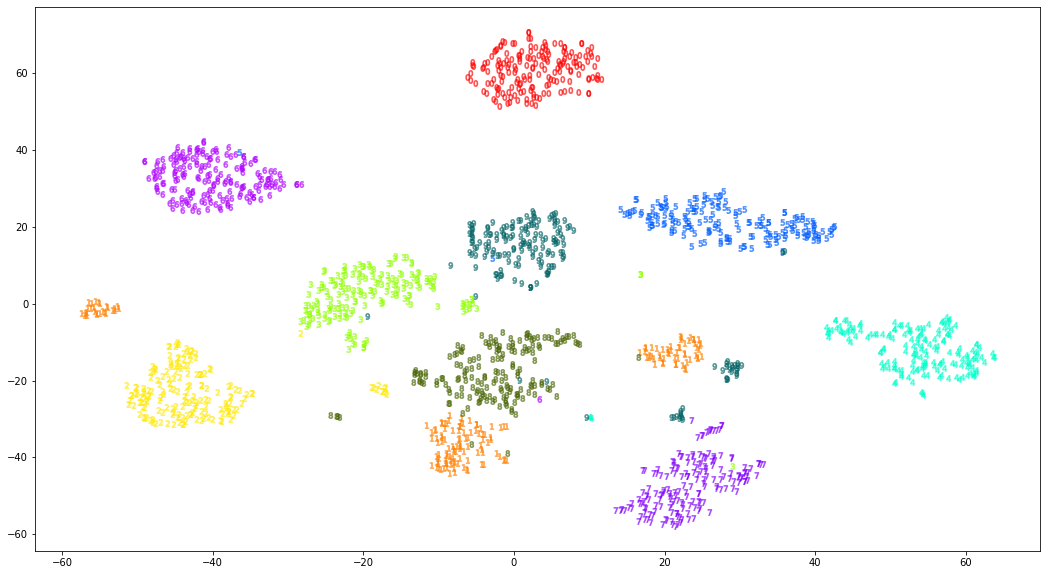

In [43]:
fig, ax = plt.subplots(ncols=1, figsize=(18, 10))
for l, c in zip(range(0, 10), ('#ff0000', '#ff8000', '#ffea00', '#91ff00', '#00ffcc', '#005eff', '#ae00ff', '#8200fc', '#4a6604', '#046466')):
    ax.scatter(x[y == l,0], x[y == l,1], color=c, label=f'class {l}', alpha=0.5, marker=f'${l}$')

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [44]:
score = [[[],[],[]],[[],[],[]]]
x = TSNE().fit_transform(X)
k_pred = KMeans(n_clusters=10, init='k-means++', n_init=1000).fit_predict(x)
a_pred = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(x)
score[0][0].append(silhouette_score(x, a_pred))
score[1][0].append(silhouette_score(x, k_pred))
score[0][1].append(v_measure_score(y, a_pred))
score[1][1].append(v_measure_score(y, k_pred))
score[0][2].append(rand_score(y, a_pred))
score[1][2].append(rand_score(y, k_pred))
x = X
k_pred = KMeans(n_clusters=10, init='k-means++', n_init=1000).fit_predict(x)
a_pred = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(x)
score[0][0].append(silhouette_score(x, a_pred))
score[1][0].append(silhouette_score(x, k_pred))
score[0][1].append(v_measure_score(y, a_pred))
score[1][1].append(v_measure_score(y, k_pred))
score[0][2].append(rand_score(y, a_pred))
score[1][2].append(rand_score(y, k_pred))

In [45]:
print('KMeans silhouette_score on transform data score:',score[1][0][0], 'on original data:',score[1][0][1])
print('KMeans v_measure_score on transform data score:',score[1][1][0], 'on original data:',score[1][1][1])
print('KMeans rand_score on transform data score:',score[1][2][0], 'on original data:',score[1][2][1])
print('AgglomerativeClustering silhouette_score on transform data score:',score[0][0][0], 'on original data:',score[0][0][1])
print('AgglomerativeClustering v_measure_score on transform data score:',score[0][1][0], 'on original data:',score[0][1][1])
print('AgglomerativeClustering rand_score on transform data score:',score[0][2][0], 'on original data:',score[0][2][1])

KMeans silhouette_score on transform data score: 0.6317251 on original data: 0.18252805278990428
KMeans v_measure_score on transform data score: 0.8997065439719166 on original data: 0.7448483085960801
KMeans rand_score on transform data score: 0.9749539259319852 on original data: 0.9388054577475698
AgglomerativeClustering silhouette_score on transform data score: 0.6326675 on original data: 0.17849659940596496
AgglomerativeClustering v_measure_score on transform data score: 0.9200828079767124 on original data: 0.8681701126909083
AgglomerativeClustering rand_score on transform data score: 0.9818758807366398 on original data: 0.9612333349445314


**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [46]:
score=[[],[]]
x = TSNE().fit_transform(X)
for i in range(2,30):
    a_pred = AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(x)
    score[0].append(rand_score(y, a_pred))
    score[1].append(v_measure_score(y, a_pred))

Maximum rand_score in AgglomerativeClustering is 12
Maximum v_measure_score in AgglomerativeClustering is 12


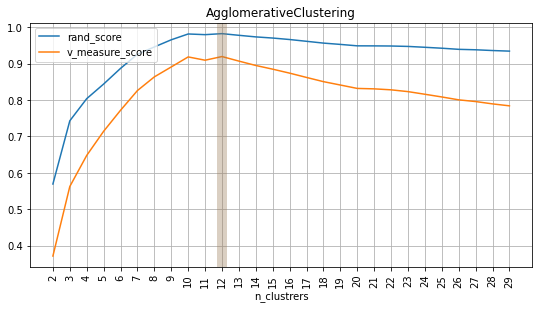

In [47]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2,30), score[0], label='rand_score')
plt.plot(range(2,30), score[1], color='C1', label='v_measure_score')
plt.xticks(range(2,30), rotation='vertical')
print('Maximum rand_score in AgglomerativeClustering is', range(2,30)[np.argmax(score[0])])
print('Maximum v_measure_score in AgglomerativeClustering is', range(2,30)[np.argmax(score[1])])
plt.axvline(range(2,30)[np.argmax(score[0])], lw=10, alpha=0.2)
plt.axvline(range(2,30)[np.argmax(score[1])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_clustrers')
plt.title('AgglomerativeClustering')              
plt.show()

In [48]:
x = TSNE().fit_transform(X)
a_pred = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(x)

In [49]:
print('AgglomerativeClustering score:',rand_score(y,a_pred))

AgglomerativeClustering score: 0.97954026322019


In [50]:
mean_num_a=[]
for num in range(10):
    mean_num_a.append([])
    for c in range(8):
        mean_num_a[num].append([])
        for v in range(8):
            mean_num_a[num][c].append(digits.images[a_pred==num,c,v].mean())

Центры кластеров AgglomerativeClustering с 10 кластерами


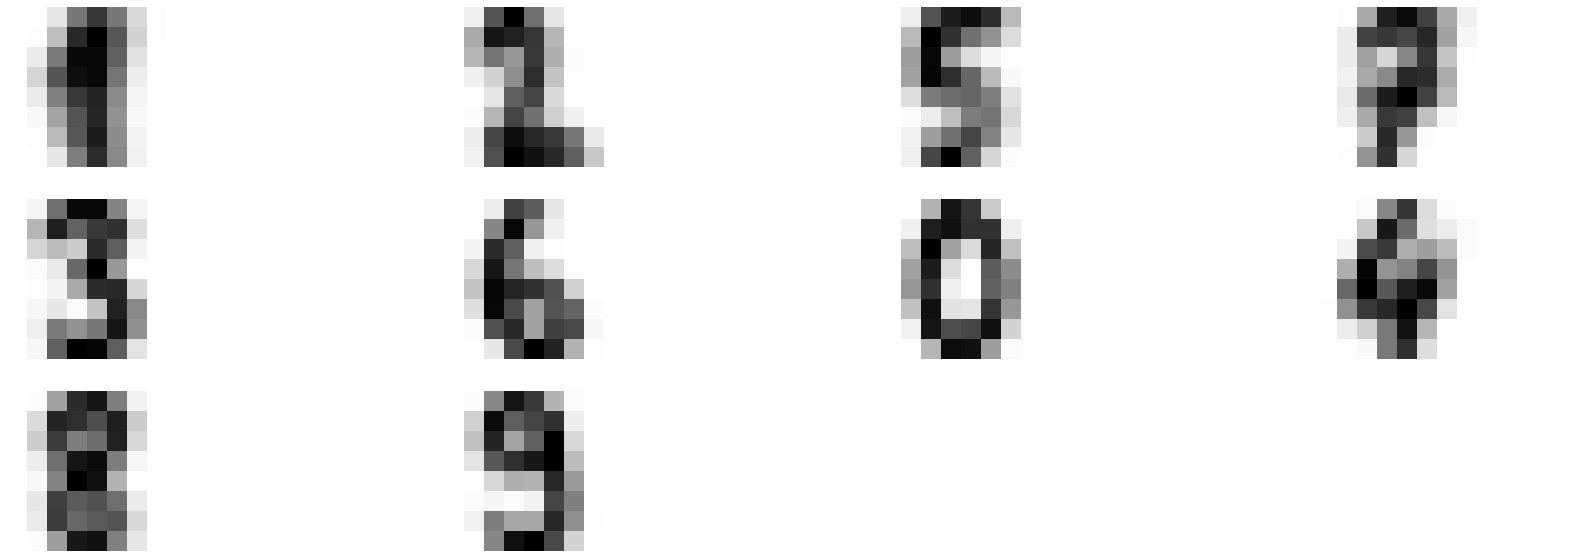

In [51]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
print('Центры кластеров AgglomerativeClustering с 10 кластерами')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_a):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

In [52]:
x = TSNE().fit_transform(X)
a_pred = AgglomerativeClustering(n_clusters=12, linkage='ward').fit_predict(x)

In [53]:
print('AgglomerativeClustering score:',rand_score(y,a_pred))

AgglomerativeClustering score: 0.9735106642721785


In [54]:
mean_num_a=[]
for num in range(12):
    mean_num_a.append([])
    for c in range(8):
        mean_num_a[num].append([])
        for v in range(8):
            mean_num_a[num][c].append(digits.images[a_pred==num,c,v].mean())

Центры кластеров AgglomerativeClustering с 12 кластерами


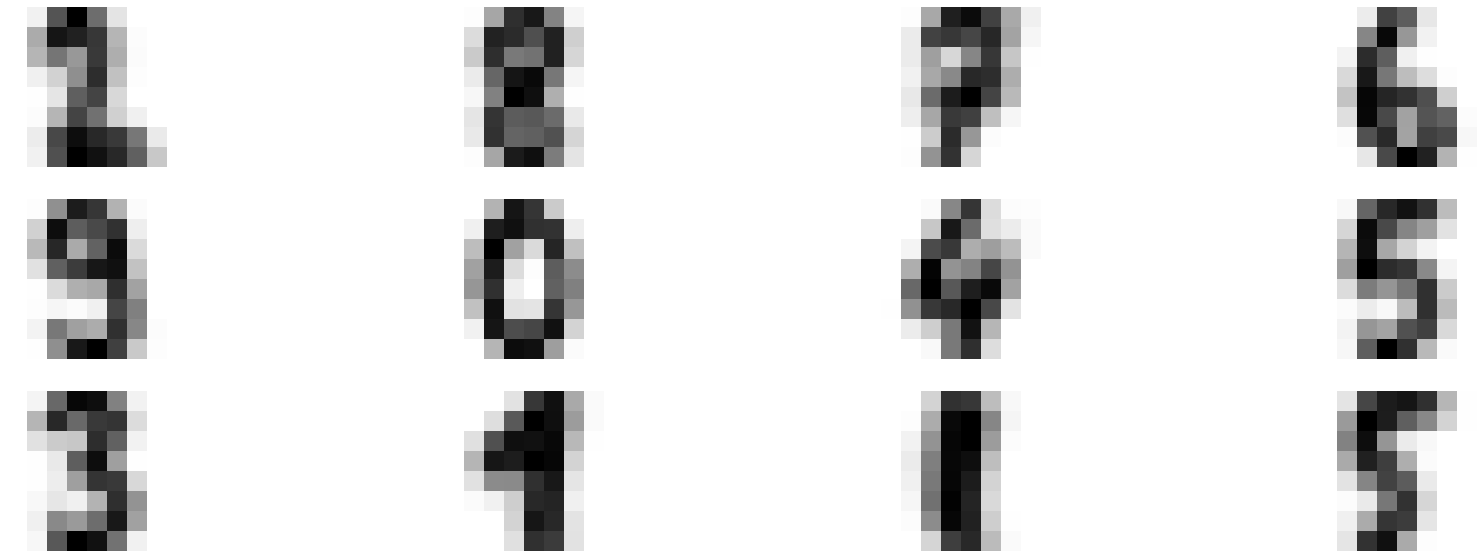

In [55]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
print('Центры кластеров AgglomerativeClustering с 12 кластерами')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_a):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Более осмысленные кластеры дает иерархическая кластеризация, но максмиальное значения силуэта дает KMeans, а в остальных случаях иерархическая кластеризация.

Используя алгоритм TSNE мы уменьшили ращмер и улучшили клатаризацию, а алгоритмом TruncatedSVD vs evtyьшаем размерность и качество кластеризации.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [56]:
data = fetch_openml(name='mnist_784')

In [57]:
data

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [58]:
X=data.data
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
y=data.target
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [60]:
images=[]
for i in range(10):
    a = X[y==f'{i}'].head(1)
    images.append([])
    for w in range(28):
        images[i].append([])
        for z in range(1,29):
            images[i][w].append(float(a[f'pixel{w*28+z}']))

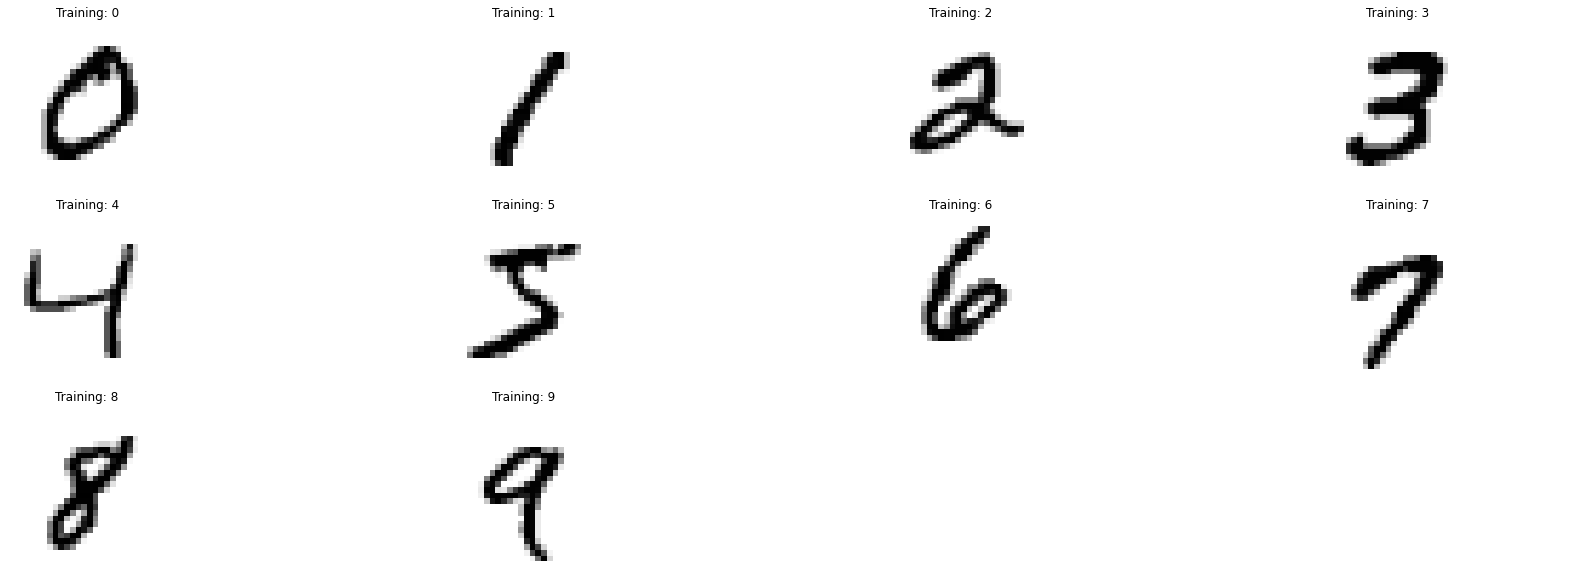

In [61]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 10))
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image, label in zip(axes.flatten(), images, range(10)):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

x=TSNE().fit_transform(X)

result = pd.DataFrame({'id': range(70000), 'X': x[:,0], 'Y':x[:,1]})
result.to_csv('TSNEdata.csv', index=True)


эти данные я заранне скомпилировал и выгрузил, так как это занаяло около 20 мин, если хотите можете из markdown выбрать python и сами скомпилировать.

In [62]:
a = pd.read_csv('TSNEdata.csv')
x = a[['X', 'Y']].values.__array__()

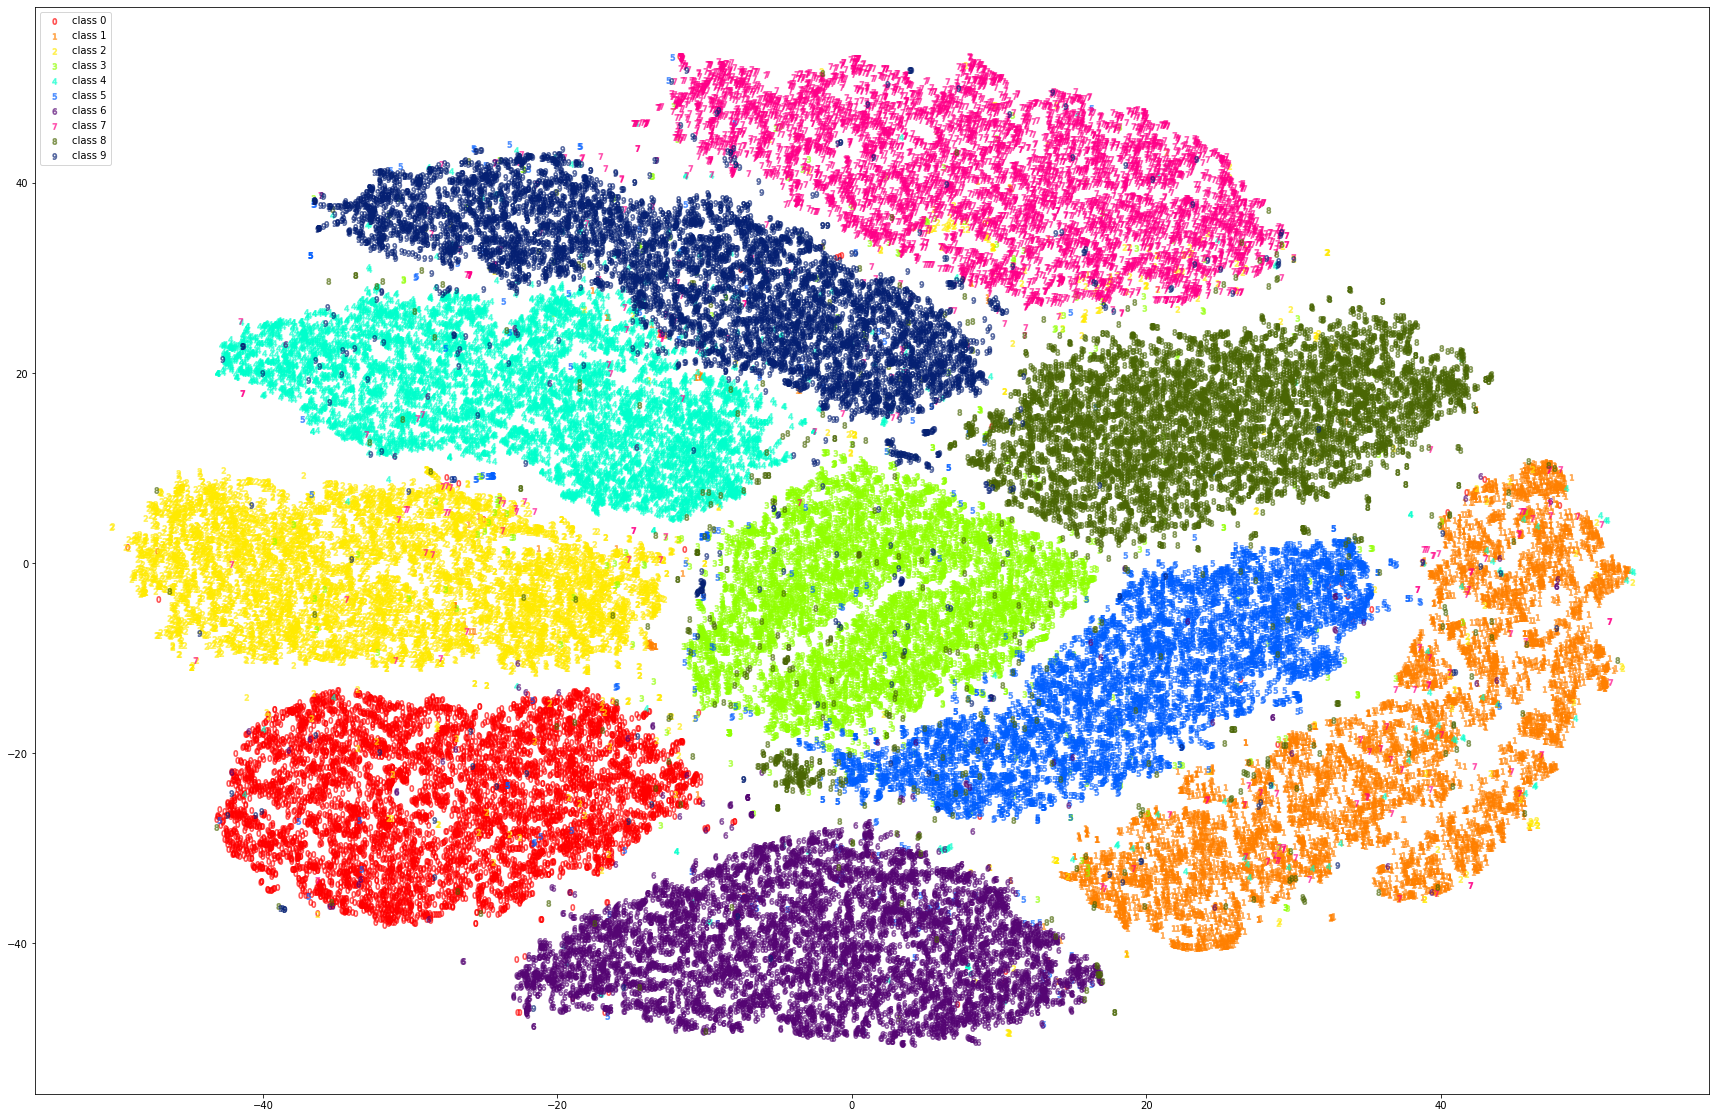

In [63]:
fig, ax = plt.subplots(ncols=1, figsize=(30, 20))
for l, c in zip(range(0, 10), ('#ff0000', '#ff8000', '#ffea00', '#91ff00', '#00ffcc', '#005eff', '#550573', '#ff0088', '#4a6604', '#052073')):
    ax.scatter(x[y == f'{l}',0], x[y == f'{l}',1], color=c, label=f'class {l}', alpha=0.5, marker=f'${l}$')
ax.legend(loc='upper left')

In [64]:
k_pred_TSNE = KMeans(n_clusters=10,n_init=10).fit_predict(x)
k_pred = KMeans(n_clusters=10,n_init=10).fit_predict(X)

In [65]:
print('KMEans score on original data:',rand_score(y,k_pred))
print('KMEans score on TSNE data:',rand_score(y,k_pred_TSNE))

KMEans score on original data: 0.8840324416879425
KMEans score on TSNE data: 0.9351688624123202


Как видим алгоритм TSNE неплохо увеличил score

In [66]:
k_pred = k_pred_TSNE
mean_num_k=[]
for num in range(10):
    mean_num_k.append([])
    for c in range(28):
        mean_num_k[num].append([])
        for v in range(28):
            mean_num_k[num][c].append(X[k_pred==num][f'pixel{c*28+v+1}'].mean())

In [67]:
mean_num_orig=[]
for num in range(10):
    mean_num_orig.append([])
    for c in range(28):
        mean_num_orig[num].append([])
        for v in range(28):
            mean_num_orig[num][c].append(X[y==f'{num}'][f'pixel{c*28+v+1}'].mean())

Центры кластеров с оригинальной кластеризации


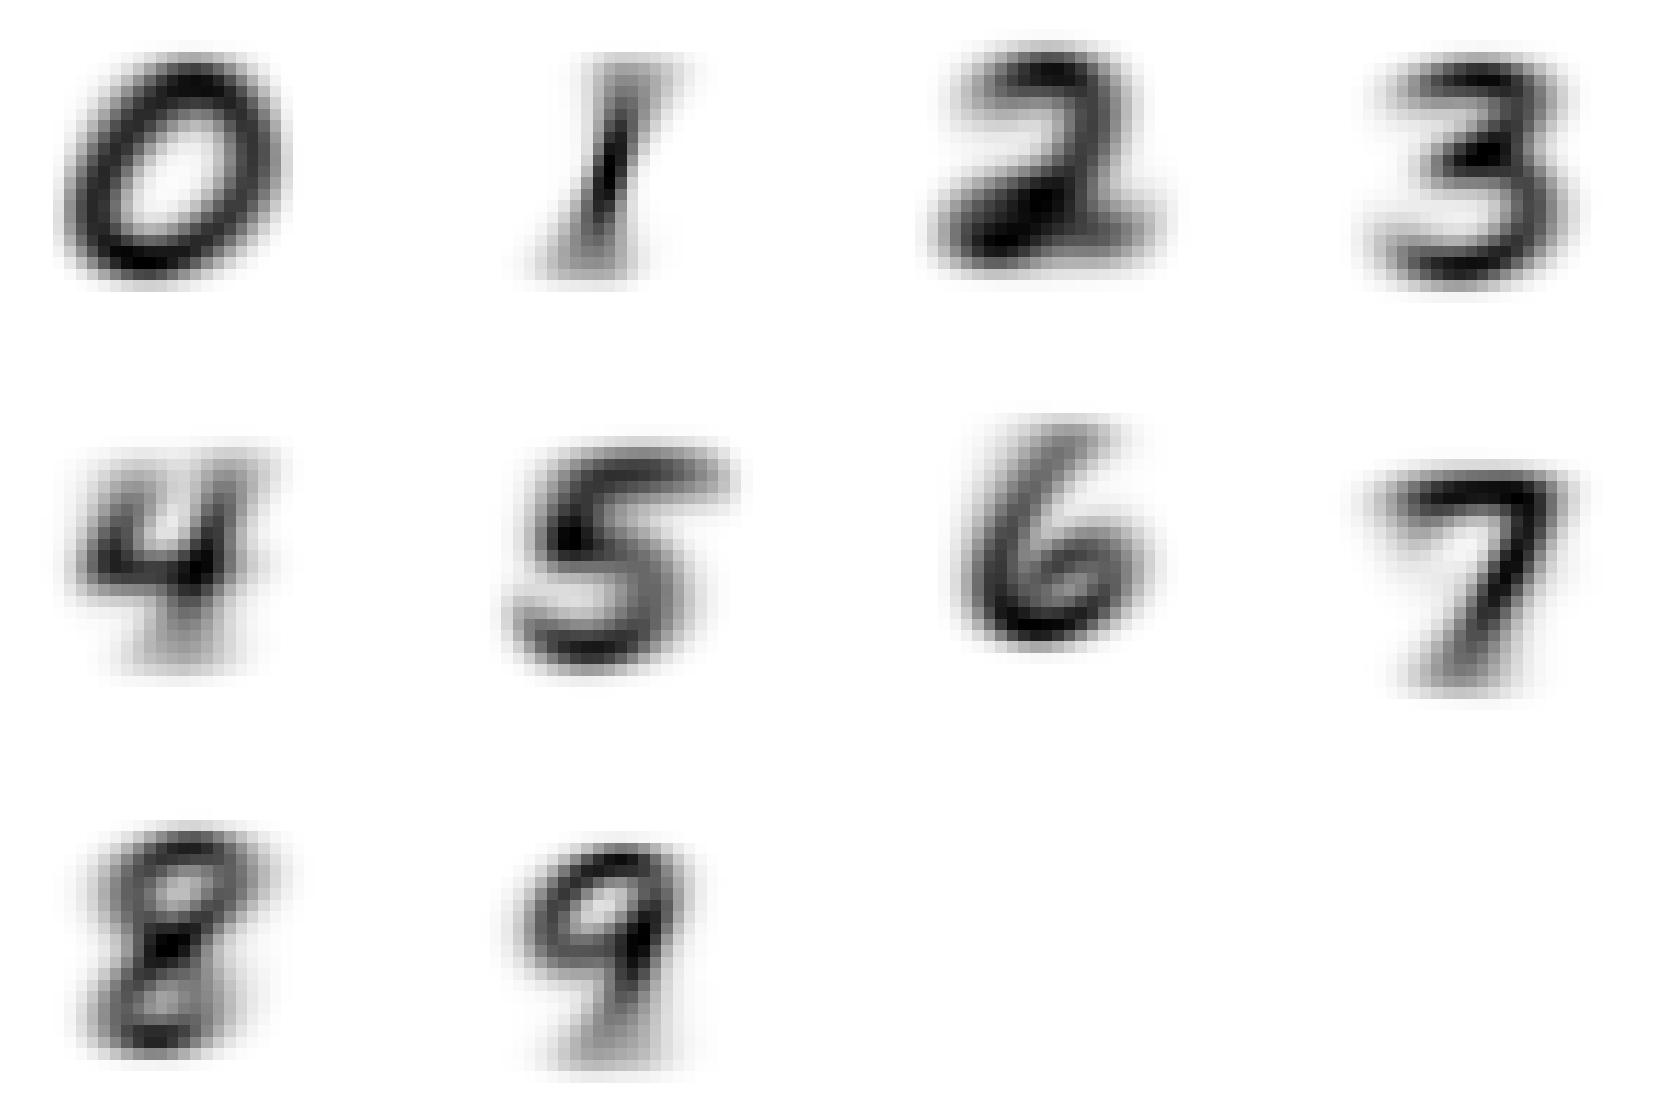

In [68]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
print(f'Центры кластеров с оригинальной кластеризации')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_orig):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

Центры кластеров KMeans с 10 кластерами на данных TSNE


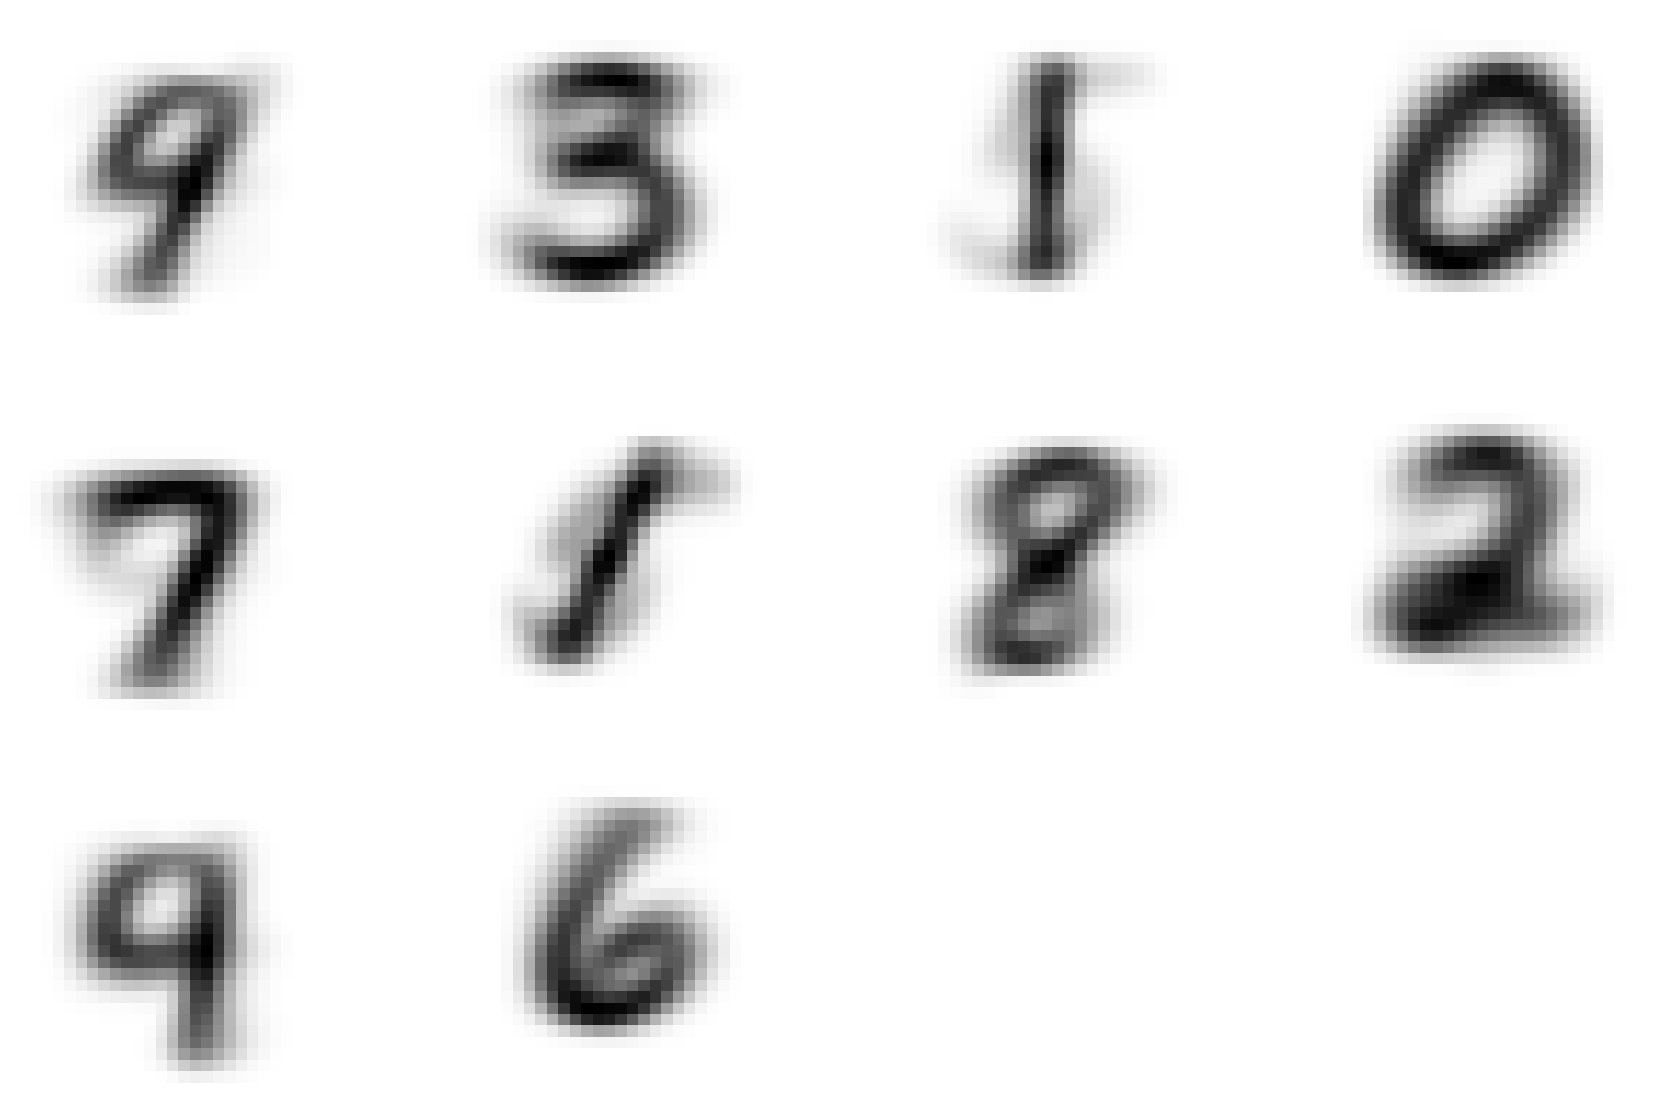

In [69]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
print(f'Центры кластеров KMeans с {10} кластерами на данных TSNE')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_k):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

Как мы можем заметить, что у еденицы есть слабое очертание пятерки и у четверки и семерки есть слабое очертание девятки. А по координатной плоскости выше можно посмотреть кто на кого похож и где у нас ошибки.

In [70]:
score=[[],[]]
for i in range(2,30):
    k_pred = KMeans(n_clusters=i, n_init=10).fit_predict(x)
    score[0].append(rand_score(y, k_pred))
    score[1].append(v_measure_score(y, k_pred))

Maximum rand_score in KMeans is 13 is 0.9443161955374872
Maximum v_measure_score in KMeans is 21 is 0.7665686545604629


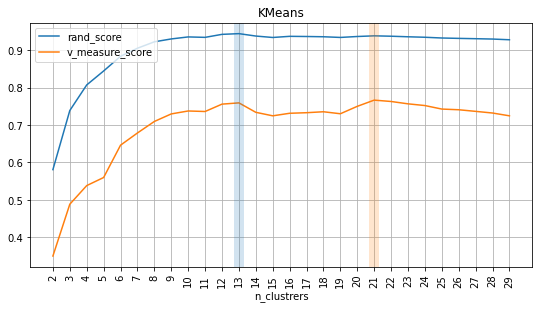

In [71]:
plt.figure(figsize=(9, 4.5))
plt.plot(range(2,30), score[0], label='rand_score')
plt.plot(range(2,30), score[1], color='C1', label='v_measure_score')
plt.xticks(range(2,30), rotation='vertical')
print('Maximum rand_score in KMeans is', range(2,30)[np.argmax(score[0])], 'is', np.max(score[0]))
print('Maximum v_measure_score in KMeans is', range(2,30)[np.argmax(score[1])], 'is', np.max(score[1]))
plt.axvline(range(2,30)[np.argmax(score[0])], lw=10, alpha=0.2)
plt.axvline(range(2,30)[np.argmax(score[1])], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('n_clustrers')
plt.title('KMeans')              
plt.show()

In [72]:
k_pred_TSNE = KMeans(n_clusters=12,n_init=10).fit_predict(x)
k_pred = KMeans(n_clusters=12,n_init=10).fit_predict(X)

In [73]:
print('KMEans score on original data:',rand_score(y,k_pred))
print('KMEans score on TSNE data:',rand_score(y,k_pred_TSNE))

KMEans score on original data: 0.8956407667048305
KMEans score on TSNE data: 0.9439145338810963


In [74]:
k_pred = k_pred_TSNE
mean_num_k=[]
for num in range(12):
    mean_num_k.append([])
    for c in range(28):
        mean_num_k[num].append([])
        for v in range(28):
            mean_num_k[num][c].append(X[k_pred==num][f'pixel{c*28+v+1}'].mean())

Центры кластеров KMeans с 12 кластерами на данных TSNE


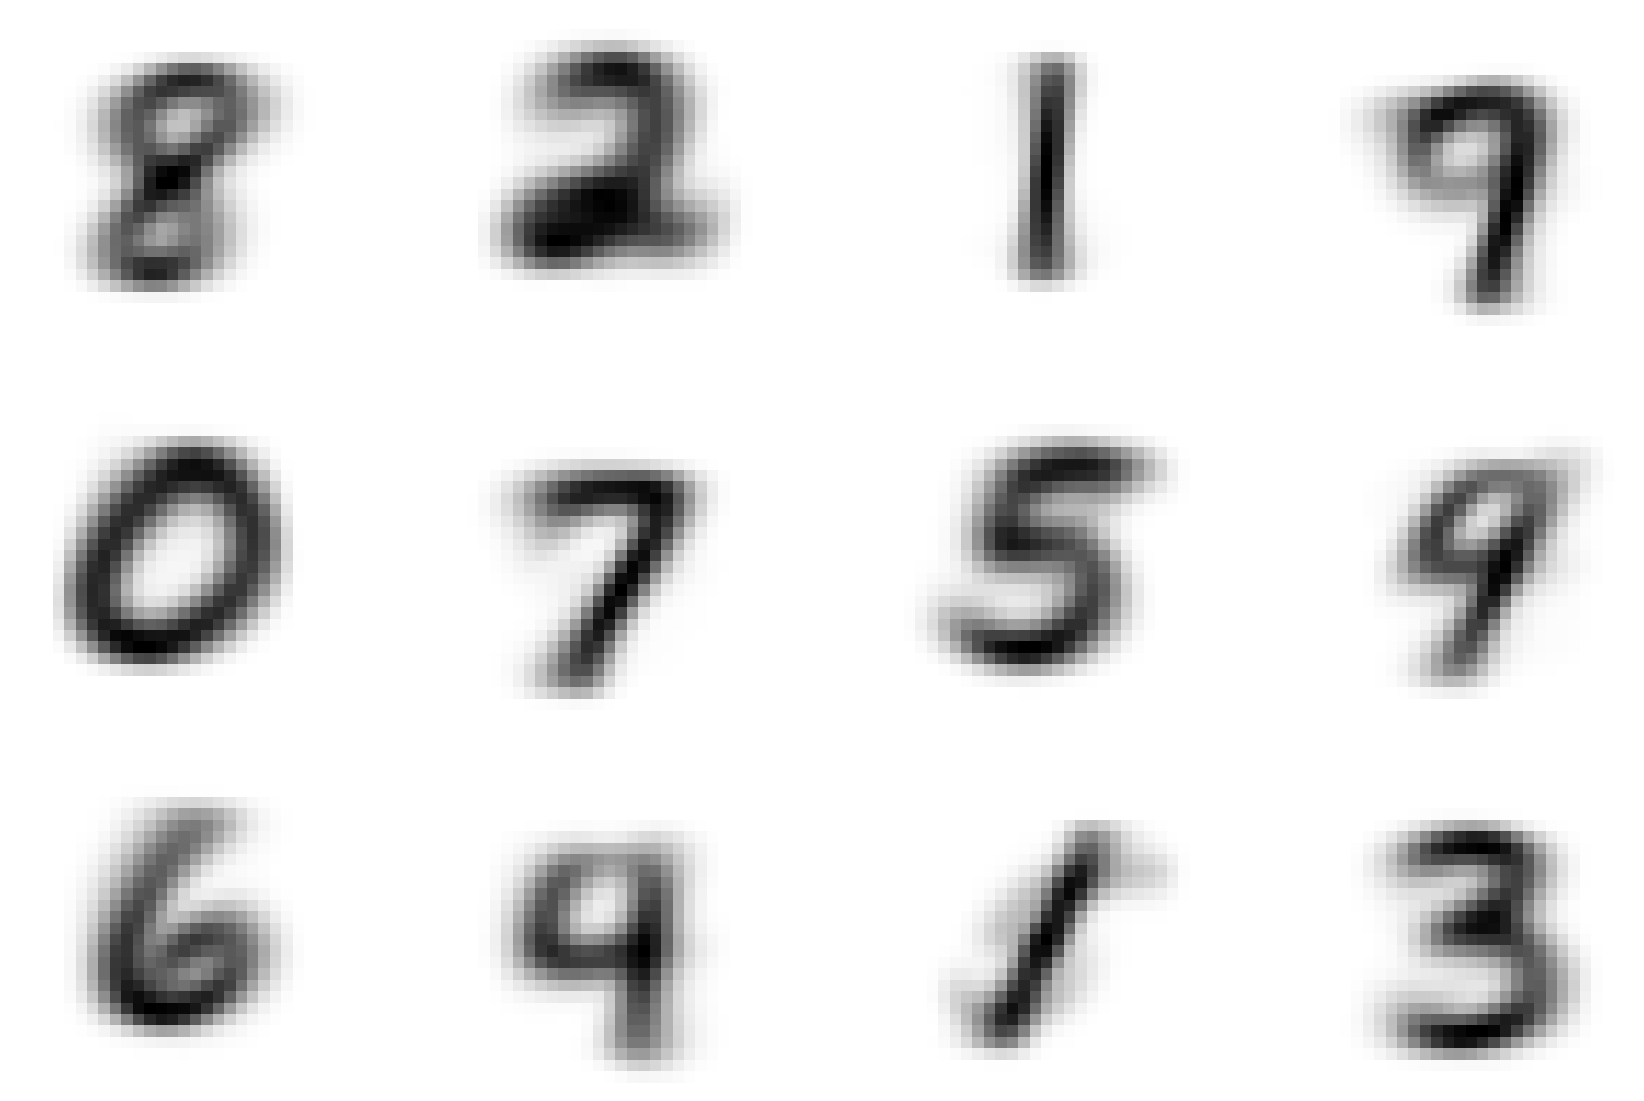

In [75]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
print(f'Центры кластеров KMeans с {12} кластерами на данных TSNE')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_k):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

In [76]:
k_pred_TSNE = KMeans(n_clusters=21,n_init=10).fit_predict(x)
k_pred = KMeans(n_clusters=21,n_init=10).fit_predict(X)

In [77]:
print('KMEans score on original data:',rand_score(y,k_pred))
print('KMEans score on TSNE data:',rand_score(y,k_pred_TSNE))

KMEans score on original data: 0.9086001812270788
KMEans score on TSNE data: 0.9385174012689977


In [78]:
k_pred = k_pred_TSNE
mean_num_k=[]
for num in range(21):
    mean_num_k.append([])
    for c in range(28):
        mean_num_k[num].append([])
        for v in range(28):
            mean_num_k[num][c].append(X[k_pred==num][f'pixel{c*28+v+1}'].mean())

Центры кластеров KMeans с 21 кластерами на данных TSNE


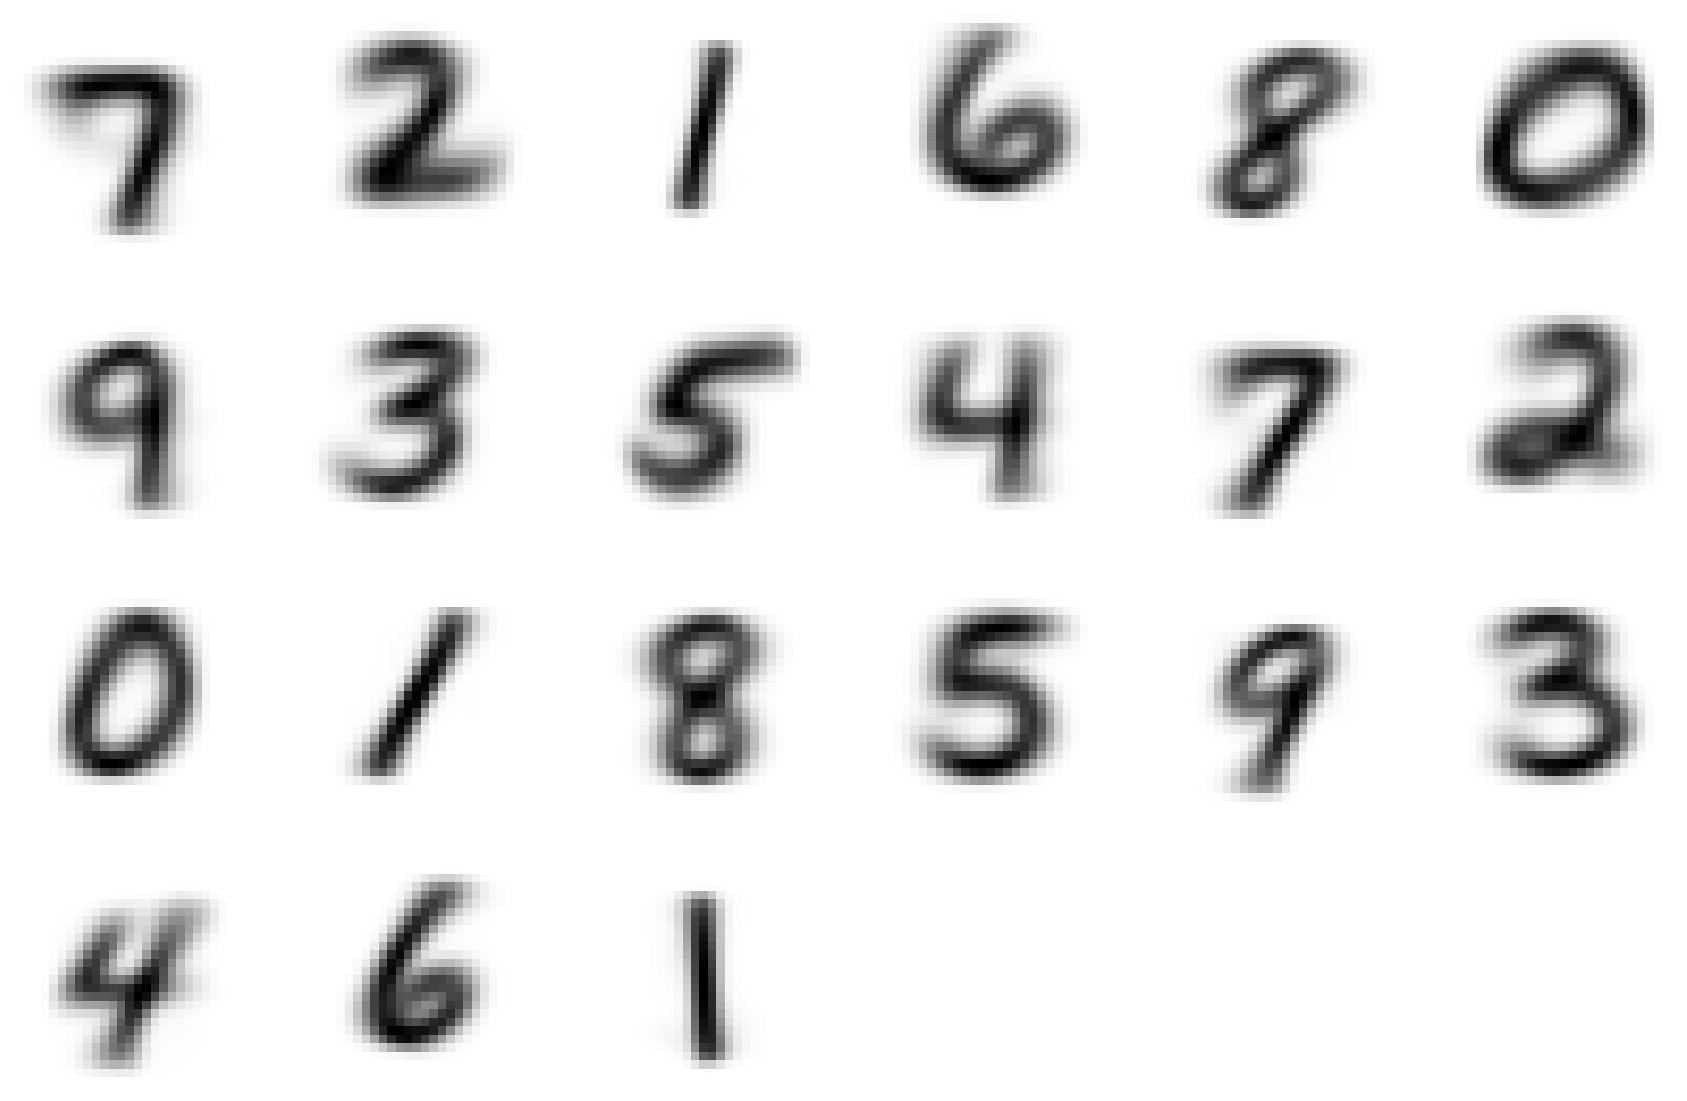

In [79]:
_, axes = plt.subplots(nrows=4, ncols=6, figsize=(30, 20))
print(f'Центры кластеров KMeans с {21} кластерами на данных TSNE')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_k):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

Как мы видим с 21 кластером очертание цифр самые четкие, хотя скор на TSNE неотличается, а вот на оригинальных данных отличие значительное

a_pred = AgglomerativeClustering(n_clusters=10, linkage='ward').fit_predict(x)

result = pd.DataFrame({'id': range(70000), 'X': a_pred})
result.to_csv('TSNEdata_pred.csv', index=True)

Так как AgglomerativeClustering выполняется намного дольше чем KMeans, у меня примерно 6 ЧАСОВ!!!!!! то я тоже сохраню это в файл.

In [80]:
a = pd.read_csv('TSNEdata_pred.csv')
a_pred = a['X'].values.__array__()

In [81]:
print('AgglomerativeClustering score:',rand_score(y,a_pred))

AgglomerativeClustering score: 0.9519643831646575


In [82]:
mean_num_a=[]
for num in range(10):
    mean_num_a.append([])
    for c in range(28):
        mean_num_a[num].append([])
        for v in range(28):
            mean_num_a[num][c].append(X[a_pred==num][f'pixel{c*28+v+1}'].mean())

Центры кластеров AgglomerativeClustering с 10 кластерами


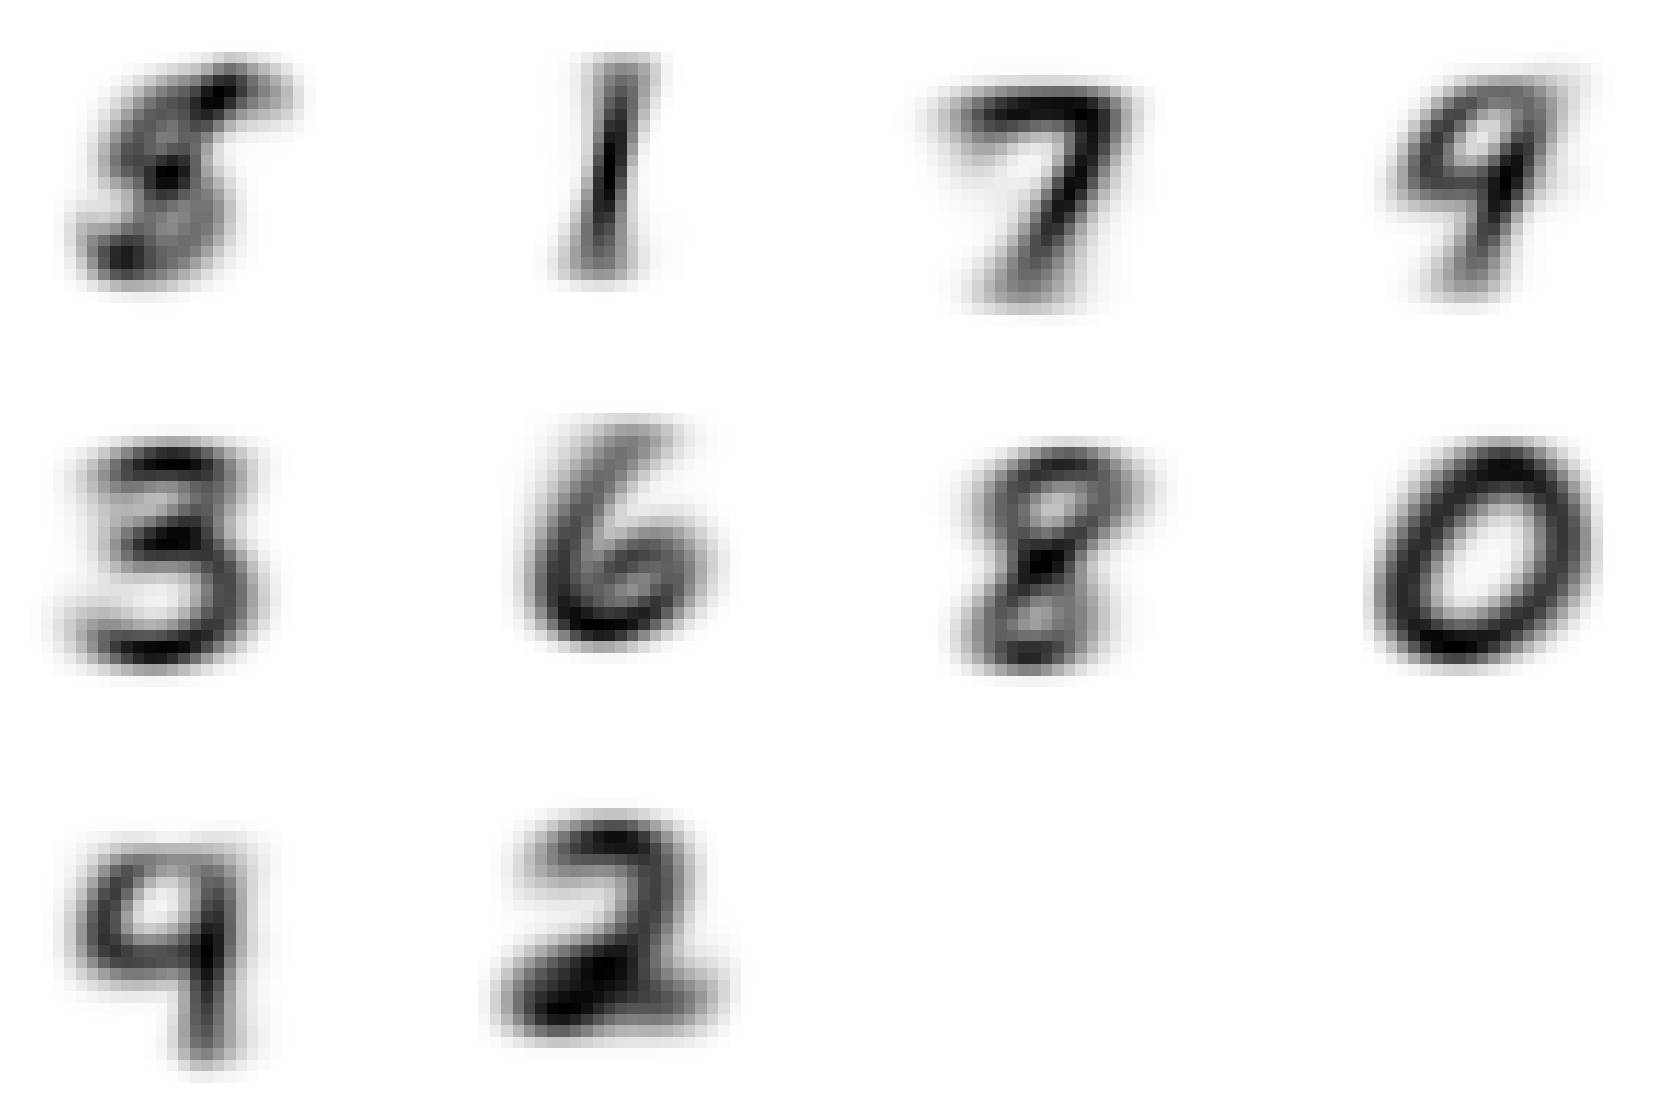

In [83]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
print(f'Центры кластеров AgglomerativeClustering с {10} кластерами')
for ax in axes.flatten():
    ax.set_axis_off()
for ax, image in zip(axes.flatten(), mean_num_a):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.set_title('Training: %i' % label)

Как мы видем, у AgglomerativeClustering скор лучше, чем у KMeans, но он выполняется намного дольше 5 часов или 20 мин, а это очень существенная разница, а скор не на столько лучше. По силуэту цифр у них ситуация примерно аналагичная.